# Entrenamiento y Evaluación de Modelos
## Proyecto: Clasificación de Riesgo Crediticio

### Objetivos de esta fase:
1. **Selección de Características**: Aplicar técnicas de reducción dimensional
2. **Entrenamiento de Modelos**: Implementar 3 algoritmos desde cero
3. **Evaluación Exhaustiva**: Métricas completas y validación cruzada  
4. **Optimización**: Ajuste de hiperparámetros para mejor rendimiento
5. **Persistencia**: Guardar modelos entrenados para uso futuro

## 0. Setup y Carga de Datos

In [20]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import json
import time

# Importar sklearn para PCA, métricas y optimización
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix as cm, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

project_root = os.path.abspath('..')
sys.path.insert(0, os.path.join(project_root, 'src'))

from models import LogisticRegressionMulticlass, SVMMulticlass
from evaluation.metrics import (
    ModelEvaluator, FeatureSelector, ModelPersistence,
    accuracy_score, precision_score, recall_score
)

print("Configuración completada exitosamente")

Configuración completada exitosamente


In [14]:
processed_dir = os.path.join(project_root, 'data', 'processed')
experiments_dir = os.path.join(project_root, 'experiments')
os.makedirs(experiments_dir, exist_ok=True)

print("CARGA DE DATOS PREPROCESADOS")
print("="*50)

# Cargar datos
X_train = pd.read_csv(os.path.join(processed_dir, 'X_train_processed.csv'))
X_test = pd.read_csv(os.path.join(processed_dir, 'X_test_processed.csv'))
y_train = pd.read_csv(os.path.join(processed_dir, 'y_train_processed.csv'))['nivel_riesgo_encoded'].values

# Cargar metadatos
with open(os.path.join(processed_dir, 'preprocessing_metadata.json'), 'r') as f:
    metadata = json.load(f)

# Cargar nombres de features
with open(os.path.join(processed_dir, 'feature_names.txt'), 'r') as f:
    feature_names = f.read().strip().split('\n')

print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"Features: {len(feature_names)}")
print(f"Clases: {metadata['target_classes']}")
print(f"Distribución: {np.bincount(y_train)}")

CARGA DE DATOS PREPROCESADOS
X_train: (20000, 37)
X_test: (5000, 37)
y_train: (20000,)
Features: 37
Clases: ['Alto', 'Bajo', 'Medio']
Distribución: [ 3015  5968 11017]


## 1. Análisis y Selección de Características

### 1.1 Análisis de Correlación entre Features

In [15]:
print("ANÁLISIS DE CORRELACIÓN")
print("="*50)

# Filtrar features altamente correlacionadas
features_to_keep_corr, features_to_remove_corr = FeatureSelector.correlation_filter(
    X_train.values, threshold=0.95
)

print(f"Features originales: {X_train.shape[1]}")
print(f"Features a mantener (correlación): {len(features_to_keep_corr)}")
print(f"Features removidas (correlación): {len(features_to_remove_corr)}")

if features_to_remove_corr:
    print("\nFeatures removidas por alta correlación:")
    for idx in features_to_remove_corr:
        print(f"  {feature_names[idx]}")

# Aplicar filtro de correlación
X_train_corr = X_train.iloc[:, features_to_keep_corr]
X_test_corr = X_test.iloc[:, features_to_keep_corr]
feature_names_corr = [feature_names[i] for i in features_to_keep_corr]

print(f"\nDimensiones después de filtro de correlación:")
print(f"X_train: {X_train_corr.shape} | X_test: {X_test_corr.shape}")

ANÁLISIS DE CORRELACIÓN
Features originales: 37
Features a mantener (correlación): 36
Features removidas (correlación): 1

Features removidas por alta correlación:
  score_riesgo_historico

Dimensiones después de filtro de correlación:
X_train: (20000, 36) | X_test: (5000, 36)


### 1.2 Selección Univariada con F-test

In [16]:
print("SELECCIÓN UNIVARIADA (F-TEST)")
print("="*50)

# Seleccionar top 20 features
k_best = min(20, X_train_corr.shape[1])
selected_features, f_scores = FeatureSelector.univariate_selection(
    X_train_corr.values, y_train, k_best=k_best
)

print(f"Top {k_best} features seleccionadas:")
feature_importance_pairs = [(feature_names_corr[i], f_scores[i]) for i in selected_features]
feature_importance_pairs.sort(key=lambda x: x[1], reverse=True)

for i, (feature, score) in enumerate(feature_importance_pairs):
    print(f"{i+1:2d}. {feature[:35]:35} | F-score: {score:.3f}")

# Aplicar selección
X_train_selected = X_train_corr.iloc[:, selected_features]
X_test_selected = X_test_corr.iloc[:, selected_features]
feature_names_selected = [feature_names_corr[i] for i in selected_features]

print(f"\nDimensiones finales después de selección:")
print(f"X_train: {X_train_selected.shape} | X_test: {X_test_selected.shape}")

SELECCIÓN UNIVARIADA (F-TEST)
Top 20 features seleccionadas:
 1. deuda_total                         | F-score: 7605.176
 2. retrasos_pago_ultimos_6_meses       | F-score: 3124.141
 3. puntuacion_credito_bureau           | F-score: 1176.937
 4. ingresos_inversion                  | F-score: 269.126
 5. score_capacidad_pago                | F-score: 121.284
 6. sector_laboral                      | F-score: 4.943
 7. ratio_deuda_ingresos                | F-score: 3.382
 8. porcentaje_utilizacion_credito      | F-score: 3.325
 9. antiguedad_laboral_meses            | F-score: 2.627
10. numero_cuentas_cerradas             | F-score: 2.452
11. maximo_retraso_pago_dias            | F-score: 2.219
12. propiedad_vivienda                  | F-score: 2.064
13. patrimonio_neto                     | F-score: 2.005
14. cambios_en_habitos_pago             | F-score: 1.537
15. saldo_promedio_bancario             | F-score: 1.292
16. estado_civil                        | F-score: 1.078
17. numero_emp

### 1.3 Reducción Dimensional con PCA

ANÁLISIS DE COMPONENTES PRINCIPALES (PCA)
Componentes principales seleccionados: 18
Varianza explicada acumulada: 0.953
Dimensiones PCA - Train: (20000, 18) | Test: (5000, 18)


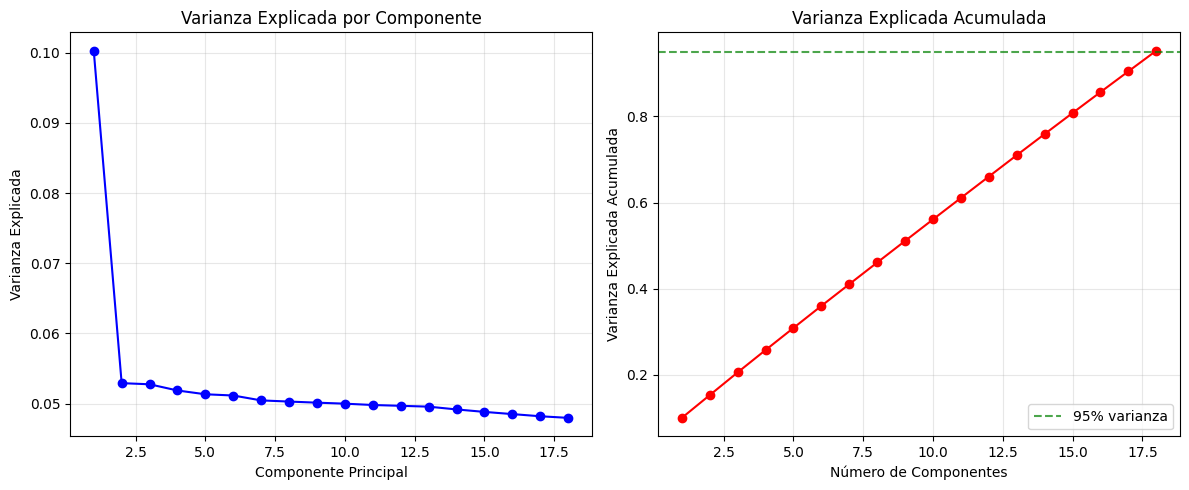


Primeras 5 componentes - varianza explicada:
  PC1: 0.1003 (10.03%)
  PC2: 0.0529 (5.29%)
  PC3: 0.0527 (5.27%)
  PC4: 0.0519 (5.19%)
  PC5: 0.0513 (5.13%)

Conclusión PCA:
- Se redujo de 20 a 18 dimensiones
- Conservando 95.3% de la varianza total
- Reducción dimensional: 10.0%


In [17]:
print("ANÁLISIS DE COMPONENTES PRINCIPALES (PCA)")
print("="*50)

# Usar sklearn PCA manteniendo 95% de varianza
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_selected.values)
X_test_pca = pca.transform(X_test_selected.values)

n_components = pca.n_components_
explained_variance_ratio = pca.explained_variance_ratio_
total_variance = np.sum(explained_variance_ratio)

print(f"Componentes principales seleccionados: {n_components}")
print(f"Varianza explicada acumulada: {total_variance:.3f}")
print(f"Dimensiones PCA - Train: {X_train_pca.shape} | Test: {X_test_pca.shape}")

# Visualizar varianza explicada
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(explained_variance_ratio) + 1), 
         explained_variance_ratio, 'bo-', markersize=6)
plt.xlabel('Componente Principal')
plt.ylabel('Varianza Explicada')
plt.title('Varianza Explicada por Componente')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
cumsum_variance = np.cumsum(explained_variance_ratio)
plt.plot(range(1, len(cumsum_variance) + 1), cumsum_variance, 'ro-', markersize=6)
plt.axhline(y=0.95, color='g', linestyle='--', alpha=0.7, label='95% varianza')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('Varianza Explicada Acumulada')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nPrimeras 5 componentes - varianza explicada:")
for i, var_exp in enumerate(explained_variance_ratio[:5]):
    print(f"  PC{i+1}: {var_exp:.4f} ({var_exp*100:.2f}%)")

print(f"\nConclusión PCA:")
print(f"- Se redujo de {X_train_selected.shape[1]} a {n_components} dimensiones")
print(f"- Conservando {total_variance:.1%} de la varianza total")
print(f"- Reducción dimensional: {((X_train_selected.shape[1] - n_components) / X_train_selected.shape[1]):.1%}")

## 2. Entrenamiento de Modelos

### 2.1 Configuración de Optimización

In [21]:
print("CONFIGURACIÓN DE OPTIMIZACIÓN DE HIPERPARÁMETROS")
print("="*60)

# Usar solo los mejores datasets
datasets = {
    'feature_selected': (X_train_selected.values, X_test_selected.values, feature_names_selected),
    'pca_transformed': (X_train_pca, X_test_pca, [f'PC{i+1}' for i in range(X_train_pca.shape[1])])
}

# Grids de hiperparámetros para optimización
hyperparameter_grids = {
    'LogisticRegression': {
        'class': LogisticRegressionMulticlass,
        'param_grid': {
            'learning_rate': [0.001, 0.01, 0.1],
            'max_iterations': [500, 1000, 1500],
            'regularization': ['l1', 'l2'],
            'lambda_reg': [0.001, 0.01, 0.1]
        }
    },
    'SVM': {
        'class': SVMMulticlass,
        'param_grid': {
            'C': [0.1, 1.0, 10.0],
            'kernel': ['linear', 'rbf'],
            'learning_rate': [0.0001, 0.001, 0.01]
        }
    },
    'KNN': {
        'class': KNeighborsClassifier,
        'param_grid': {
            'n_neighbors': [3, 5, 7, 11, 15],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']
        }
    }
}

print(f"Datasets para optimización: {list(datasets.keys())}")
print(f"Algoritmos a optimizar: {list(hyperparameter_grids.keys())}")

for dataset_name, (X_tr, X_te, features) in datasets.items():
    print(f"  {dataset_name}: {X_tr.shape[0]} × {X_tr.shape[1]} features")

# Inicializar almacenamiento de resultados
optimization_results = {}
best_models = {}

CONFIGURACIÓN DE OPTIMIZACIÓN DE HIPERPARÁMETROS
Datasets para optimización: ['feature_selected', 'pca_transformed']
Algoritmos a optimizar: ['LogisticRegression', 'SVM', 'KNN']
  feature_selected: 20000 × 20 features
  pca_transformed: 20000 × 18 features


### 2.2 Optimización de Hiperparámetros con Grid Search

In [22]:
print("OPTIMIZACIÓN DE HIPERPARÁMETROS")
print("="*60)

def optimize_custom_model(model_class, param_grid, X, y, cv_folds=5, scoring='f1_macro'):
    """Optimización manual para modelos personalizados usando búsqueda en grilla"""
    from itertools import product
    
    # Generar todas las combinaciones de parámetros
    param_names = list(param_grid.keys())
    param_values = list(param_grid.values())
    param_combinations = list(product(*param_values))
    
    best_score = -1
    best_params = None
    best_model = None
    all_results = []
    
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    
    print(f"  Total combinaciones a evaluar: {len(param_combinations)}")
    
    for i, combination in enumerate(param_combinations):
        params = dict(zip(param_names, combination))
        
        # Validación cruzada para esta combinación
        fold_scores = []
        
        for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
            X_fold_train, X_fold_val = X[train_idx], X[val_idx]
            y_fold_train, y_fold_val = y[train_idx], y[val_idx]
            
            try:
                # Crear y entrenar modelo
                model = model_class(**params, random_state=42 + fold)
                model.fit(X_fold_train, y_fold_train)
                
                # Evaluar
                y_pred = model.predict(X_fold_val)
                
                if scoring == 'f1_macro':
                    score = f1_score(y_fold_val, y_pred, average='macro')
                else:  # accuracy
                    score = accuracy_score(y_fold_val, y_pred)
                
                fold_scores.append(score)
                
            except Exception as e:
                print(f"    Error en combinación {i+1}: {e}")
                fold_scores.append(0)  # Score mínimo para combinaciones que fallan
                break
        
        if len(fold_scores) == cv_folds:  # Solo si todos los folds funcionaron
            mean_score = np.mean(fold_scores)
            std_score = np.std(fold_scores)
            
            all_results.append({
                'params': params,
                'mean_score': mean_score,
                'std_score': std_score,
                'fold_scores': fold_scores
            })
            
            if mean_score > best_score:
                best_score = mean_score
                best_params = params
                # Entrenar modelo final con mejores parámetros
                best_model = model_class(**params, random_state=42)
                best_model.fit(X, y)
            
            if (i + 1) % 10 == 0 or (i + 1) == len(param_combinations):
                print(f"    Progreso: {i+1}/{len(param_combinations)} - Mejor score: {best_score:.4f}")
    
    return {
        'best_model': best_model,
        'best_params': best_params,
        'best_score': best_score,
        'all_results': all_results
    }

# Ejecutar optimización para cada algoritmo y dataset
total_optimizations = len(hyperparameter_grids) * len(datasets)
current_opt = 0

for dataset_name, (X_train_opt, X_test_opt, feature_list) in datasets.items():
    print(f"\nDATASET: {dataset_name.upper()} ({X_train_opt.shape[1]} features)")
    print("-" * 50)
    
    dataset_results = {}
    
    for model_name, config in hyperparameter_grids.items():
        current_opt += 1
        print(f"\n[{current_opt}/{total_optimizations}] Optimizando {model_name}")
        
        model_class = config['class']
        param_grid = config['param_grid']
        
        start_time = time.time()
        
        try:
            if model_name == 'KNN':
                # Usar GridSearchCV nativo de sklearn para KNN
                knn = KNeighborsClassifier()
                grid_search = GridSearchCV(
                    knn, param_grid, cv=5, 
                    scoring='f1_macro', n_jobs=-1, verbose=0
                )
                grid_search.fit(X_train_opt, y_train)
                
                result = {
                    'best_model': grid_search.best_estimator_,
                    'best_params': grid_search.best_params_,
                    'best_score': grid_search.best_score_,
                    'cv_results': grid_search.cv_results_
                }
            else:
                # Optimización manual para modelos personalizados
                result = optimize_custom_model(
                    model_class, param_grid, X_train_opt, y_train, 
                    cv_folds=5, scoring='f1_macro'
                )
            
            optimization_time = time.time() - start_time
            
            # Guardar resultados
            experiment_id = f"{dataset_name}_{model_name}_optimized"
            
            dataset_results[experiment_id] = {
                'model': result['best_model'],
                'dataset': dataset_name,
                'model_type': model_name,
                'best_params': result['best_params'],
                'best_cv_score': result['best_score'],
                'optimization_time': optimization_time,
                'n_features': X_train_opt.shape[1],
                'feature_names': feature_list
            }
            
            best_models[experiment_id] = result['best_model']
            
            print(f"  ✅ Completado en {optimization_time:.1f}s")
            print(f"  Mejores parámetros: {result['best_params']}")
            print(f"  Mejor CV F1-Score: {result['best_score']:.4f}")
            
        except Exception as e:
            print(f"  ❌ Error: {str(e)}")
            continue
    
    optimization_results[dataset_name] = dataset_results

successful_opts = len([r for ds in optimization_results.values() for r in ds.values()])
print(f"\n\nOPTIMIZACIONES COMPLETADAS: {successful_opts}/{total_optimizations}")

OPTIMIZACIÓN DE HIPERPARÁMETROS

DATASET: FEATURE_SELECTED (20 features)
--------------------------------------------------

[1/6] Optimizando LogisticRegression
  Total combinaciones a evaluar: 54
    Progreso: 10/54 - Mejor score: 0.6018
    Progreso: 10/54 - Mejor score: 0.6018
    Progreso: 20/54 - Mejor score: 0.6679
    Progreso: 20/54 - Mejor score: 0.6679
    Progreso: 30/54 - Mejor score: 0.7986
    Progreso: 30/54 - Mejor score: 0.7986
    Progreso: 40/54 - Mejor score: 0.9479
    Progreso: 40/54 - Mejor score: 0.9479
    Progreso: 50/54 - Mejor score: 0.9761
    Progreso: 50/54 - Mejor score: 0.9761
    Progreso: 54/54 - Mejor score: 0.9761
  ✅ Completado en 530.3s
  Mejores parámetros: {'learning_rate': 0.1, 'max_iterations': 1500, 'regularization': 'l1', 'lambda_reg': 0.001}
  Mejor CV F1-Score: 0.9761

[2/6] Optimizando SVM
  Total combinaciones a evaluar: 18
    Progreso: 54/54 - Mejor score: 0.9761
  ✅ Completado en 530.3s
  Mejores parámetros: {'learning_rate': 0.1, 'm

## 3. Análisis de Resultados

### 3.1 Análisis de Resultados Optimizados

In [26]:
print("ANÁLISIS DE RESULTADOS OPTIMIZADOS")
print("="*60)

# Crear DataFrame con resultados optimizados
optimization_data = []

for dataset_name, dataset_results in optimization_results.items():
    for exp_id, result in dataset_results.items():
        # Evaluar modelo en conjunto completo para métricas de entrenamiento
        X_dataset = datasets[dataset_name][0]
        y_train_pred = result['model'].predict(X_dataset)
        
        train_report = classification_report(y_train, y_train_pred, 
                                           target_names=['Alto', 'Bajo', 'Medio'], 
                                           output_dict=True, zero_division=0)
        
        optimization_data.append({
            'Experiment': exp_id,
            'Dataset': dataset_name,
            'Model': result['model_type'],
            'Features': result['n_features'],
            'Best_Params': str(result['best_params']),
            'CV_F1_Score': result['best_cv_score'],
            'Train_Accuracy': train_report['accuracy'],
            'Train_F1': train_report['macro avg']['f1-score'],
            'Optimization_Time': result['optimization_time']
        })

results_df = pd.DataFrame(optimization_data)

print("RESULTADOS DE OPTIMIZACIÓN:")
print(results_df[['Experiment', 'Model', 'Dataset', 'Features', 'CV_F1_Score', 'Optimization_Time']].to_string(index=False))

# Encontrar el mejor modelo global
best_global_idx = results_df['CV_F1_Score'].idxmax()
best_global = results_df.loc[best_global_idx]

print(f"\n\nMEJOR MODELO OPTIMIZADO:")
print(f"  Experimento: {best_global['Experiment']}")
print(f"  Algoritmo: {best_global['Model']}")
print(f"  Dataset: {best_global['Dataset']}")
print(f"  Features: {best_global['Features']}")
print(f"  CV F1-Score: {best_global['CV_F1_Score']:.4f}")
print(f"  Parámetros: {best_global['Best_Params']}")

# Análisis por algoritmo
print(f"\n\nCOMPARACIÓN POR ALGORITMO (Mejores resultados):")
algo_comparison = results_df.groupby('Model').agg({
    'CV_F1_Score': ['max', 'mean', 'std'],
    'Optimization_Time': ['mean', 'std']
}).round(4)

print(algo_comparison)

# Análisis por dataset
print(f"\n\nCOMPARACIÓN POR DATASET:")
dataset_comparison = results_df.groupby('Dataset').agg({
    'CV_F1_Score': ['max', 'mean', 'std'],
    'Features': 'first'
}).round(4)

print(dataset_comparison)

# Conclusiones automáticas
best_algorithm = results_df.loc[results_df['CV_F1_Score'].idxmax(), 'Model']
best_dataset_type = results_df.loc[results_df['CV_F1_Score'].idxmax(), 'Dataset']
max_f1 = results_df['CV_F1_Score'].max()
min_f1 = results_df['CV_F1_Score'].min()

print(f"\n\nCONCLUSIONES DE LA OPTIMIZACIÓN:")
print(f"- Mejor algoritmo: {best_algorithm}")
print(f"- Mejor tipo de dataset: {best_dataset_type}")
print(f"- Mejor F1-Score: {max_f1:.4f}")
print(f"- Mejora vs peor resultado: {max_f1 - min_f1:.4f}")
print(f"- Tiempo total de optimización: {results_df['Optimization_Time'].sum():.1f}s")

# Eficiencia por algoritmo
efficiency = results_df['CV_F1_Score'] / results_df['Optimization_Time']
most_efficient_idx = efficiency.idxmax()
most_efficient = results_df.loc[most_efficient_idx]
print(f"- Más eficiente (F1/tiempo): {most_efficient['Model']} en {most_efficient['Dataset']}")

ANÁLISIS DE RESULTADOS OPTIMIZADOS
RESULTADOS DE OPTIMIZACIÓN:
                                   Experiment              Model          Dataset  Features  CV_F1_Score  Optimization_Time
feature_selected_LogisticRegression_optimized LogisticRegression feature_selected        20     0.976117         530.290639
               feature_selected_SVM_optimized                SVM feature_selected        20     0.921430        1401.807720
               feature_selected_KNN_optimized                KNN feature_selected        20     0.744933           6.356477
 pca_transformed_LogisticRegression_optimized LogisticRegression  pca_transformed        18     0.958204         504.334776
                pca_transformed_SVM_optimized                SVM  pca_transformed        18     0.900224        1423.518998
                pca_transformed_KNN_optimized                KNN  pca_transformed        18     0.737774           5.912141


MEJOR MODELO OPTIMIZADO:
  Experimento: feature_selected_LogisticRe

### 3.2 Visualización de Resultados Optimizados

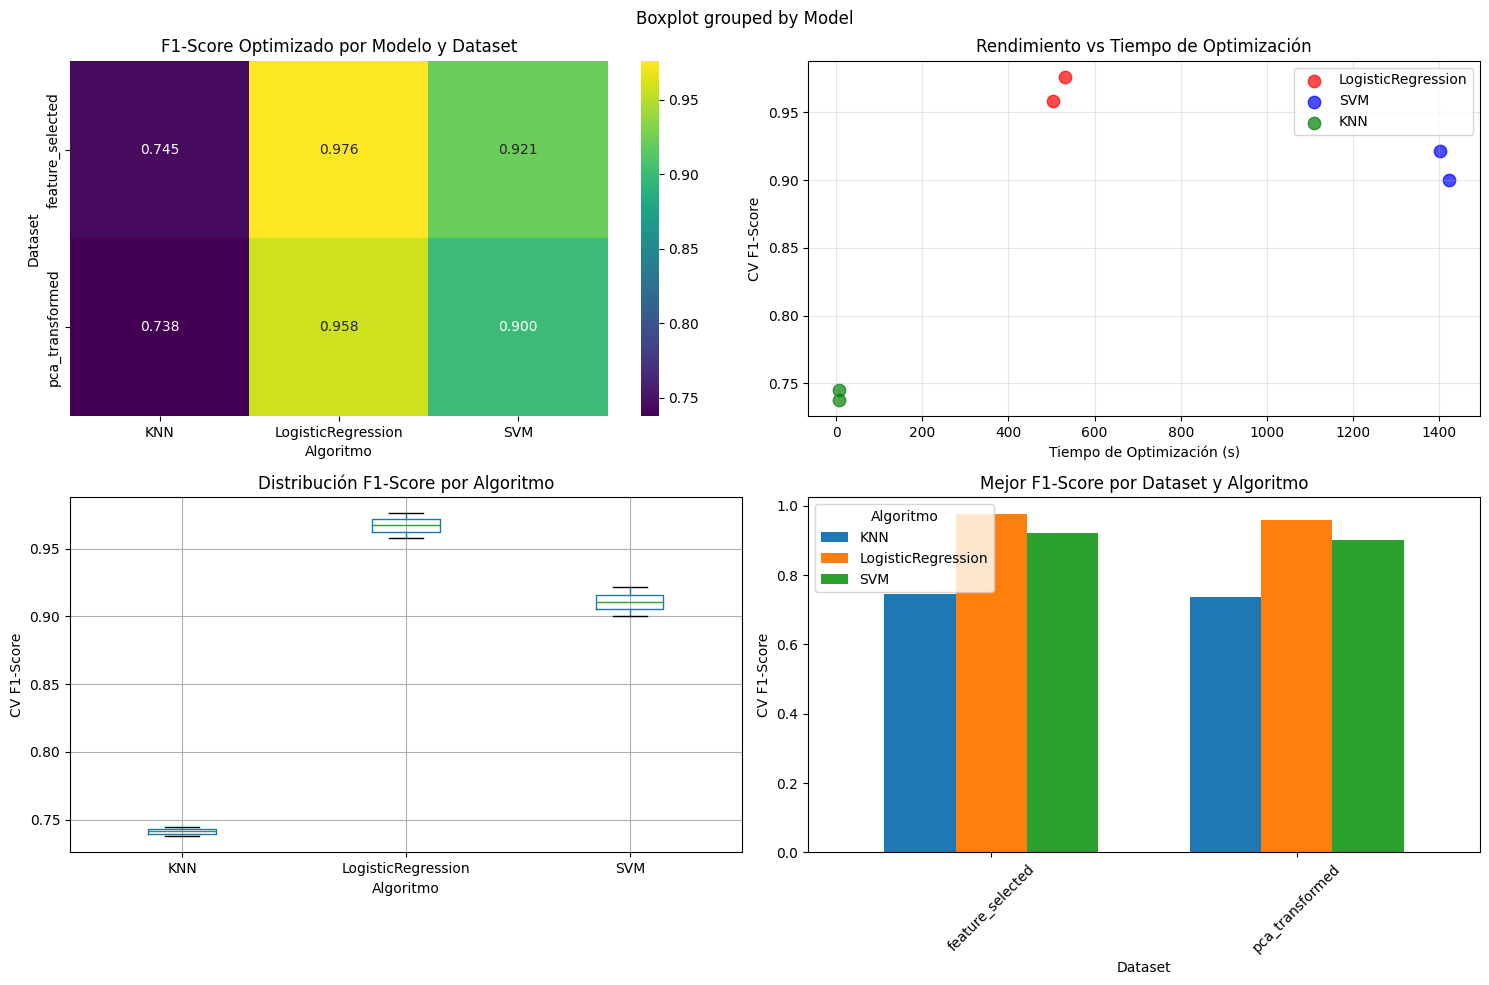


MEJORES PARÁMETROS POR ALGORITMO:

LogisticRegression:
  F1-Score: 0.9761
  Dataset: feature_selected
  learning_rate: 0.1
  max_iterations: 1500
  regularization: l1
  lambda_reg: 0.001

SVM:
  F1-Score: 0.9214
  Dataset: feature_selected
  C: 10.0
  kernel: linear
  learning_rate: 0.0001

KNN:
  F1-Score: 0.7449
  Dataset: feature_selected
  metric: manhattan
  n_neighbors: 15
  weights: uniform


In [27]:
# Visualizaciones de resultados optimizados
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. F1-Score por modelo y dataset
pivot_f1 = results_df.pivot_table(
    values='CV_F1_Score', index='Dataset', columns='Model', aggfunc='max'
)

sns.heatmap(pivot_f1, annot=True, fmt='.3f', cmap='viridis', ax=axes[0,0])
axes[0,0].set_title('F1-Score Optimizado por Modelo y Dataset')
axes[0,0].set_xlabel('Algoritmo')
axes[0,0].set_ylabel('Dataset')

# 2. F1-Score vs Tiempo de Optimización
colors = {'LogisticRegression': 'red', 'SVM': 'blue', 'KNN': 'green'}
for model in results_df['Model'].unique():
    model_data = results_df[results_df['Model'] == model]
    axes[0,1].scatter(model_data['Optimization_Time'], model_data['CV_F1_Score'], 
                     label=model, alpha=0.7, s=80, c=colors.get(model, 'gray'))

axes[0,1].set_xlabel('Tiempo de Optimización (s)')
axes[0,1].set_ylabel('CV F1-Score')
axes[0,1].set_title('Rendimiento vs Tiempo de Optimización')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. Comparación de algoritmos (box plot)
results_df.boxplot(column='CV_F1_Score', by='Model', ax=axes[1,0])
axes[1,0].set_title('Distribución F1-Score por Algoritmo')
axes[1,0].set_xlabel('Algoritmo')
axes[1,0].set_ylabel('CV F1-Score')

# 4. Barras comparativas por dataset
dataset_max_f1 = results_df.groupby(['Dataset', 'Model'])['CV_F1_Score'].max().unstack()
dataset_max_f1.plot(kind='bar', ax=axes[1,1], width=0.7)
axes[1,1].set_title('Mejor F1-Score por Dataset y Algoritmo')
axes[1,1].set_xlabel('Dataset')
axes[1,1].set_ylabel('CV F1-Score')
axes[1,1].legend(title='Algoritmo')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Mostrar mejores parámetros encontrados
print("\nMEJORES PARÁMETROS POR ALGORITMO:")
print("="*50)

for model_type in results_df['Model'].unique():
    model_best = results_df[results_df['Model'] == model_type].nlargest(1, 'CV_F1_Score').iloc[0]
    print(f"\n{model_type}:")
    print(f"  F1-Score: {model_best['CV_F1_Score']:.4f}")
    print(f"  Dataset: {model_best['Dataset']}")
    
    # Parsear parámetros desde string
    import ast
    try:
        params_dict = ast.literal_eval(model_best['Best_Params'])
        for param, value in params_dict.items():
            print(f"  {param}: {value}")
    except:
        print(f"  Parámetros: {model_best['Best_Params']}")

### 3.3 Análisis Detallado del Mejor Modelo Optimizado

In [32]:
print("ANÁLISIS DETALLADO DEL MEJOR MODELO")
print("="*50)

# Obtener información del mejor modelo
best_experiment_id = best_global['Experiment']
best_dataset_name = best_global['Dataset']
best_result = optimization_results[best_dataset_name][best_experiment_id]
best_model = best_models[best_experiment_id]

print(f"MEJOR MODELO OPTIMIZADO: {best_experiment_id}")
print(f"  Algoritmo: {best_global['Model']}")
print(f"  Dataset: {best_global['Dataset']}")
print(f"  Features: {best_global['Features']}")
print(f"  CV F1-Score: {best_global['CV_F1_Score']:.4f}")
print(f"  Tiempo de optimización: {best_global['Optimization_Time']:.1f}s")

print(f"\nPARÁMETROS OPTIMIZADOS:")
for param, value in best_result['best_params'].items():
    print(f"  {param}: {value}")

print("\nEVALUACIÓN DETALLADA:")
print("-" * 30)

# Evaluación en conjunto de entrenamiento completo
X_best = datasets[best_dataset_name][0]
y_train_pred = best_model.predict(X_best)

# Classification report detallado
print("\nClassification Report (Conjunto de Entrenamiento):")
print(classification_report(y_train, y_train_pred, 
                          target_names=['Alto', 'Bajo', 'Medio'], zero_division=0))

# Matriz de confusión
conf_matrix = cm(y_train, y_train_pred)
print(f"\nMatriz de Confusión:")
print(f"         Pred:  Alto  Bajo  Medio  Total")
class_names = ['Alto', 'Bajo', 'Medio']
for i, true_class in enumerate(class_names):
    row_total = np.sum(conf_matrix[i, :])
    print(f"Real {true_class:5}: {conf_matrix[i, 0]:5d} {conf_matrix[i, 1]:5d} {conf_matrix[i, 2]:5d} {row_total:5d}")

# Totales por columna
col_totals = np.sum(conf_matrix, axis=0)
print(f"{'Total':11}: {col_totals[0]:5d} {col_totals[1]:5d} {col_totals[2]:5d} {np.sum(conf_matrix):5d}")

# Métricas por clase
train_report = classification_report(y_train, y_train_pred, 
                                   target_names=['Alto', 'Bajo', 'Medio'], 
                                   output_dict=True, zero_division=0)

print(f"\nMétricas por Clase:")
for class_name in ['Alto', 'Bajo', 'Medio']:
    precision = train_report[class_name]['precision']
    recall = train_report[class_name]['recall']
    f1 = train_report[class_name]['f1-score']
    support = train_report[class_name]['support']
    
    print(f"  {class_name:8} | Precision: {precision:.3f} | Recall: {recall:.3f} | F1: {f1:.3f} | Support: {support:5.0f}")

print(f"\nMétricas Globales:")
print(f"  Accuracy: {train_report['accuracy']:.4f}")
print(f"  Macro Avg F1: {train_report['macro avg']['f1-score']:.4f}")
print(f"  Weighted Avg F1: {train_report['weighted avg']['f1-score']:.4f}")

ANÁLISIS DETALLADO DEL MEJOR MODELO
MEJOR MODELO OPTIMIZADO: feature_selected_LogisticRegression_optimized
  Algoritmo: LogisticRegression
  Dataset: feature_selected
  Features: 20
  CV F1-Score: 0.9761
  Tiempo de optimización: 530.3s

PARÁMETROS OPTIMIZADOS:
  learning_rate: 0.1
  max_iterations: 1500
  regularization: l1
  lambda_reg: 0.001

EVALUACIÓN DETALLADA:
------------------------------

Classification Report (Conjunto de Entrenamiento):
              precision    recall  f1-score   support

        Alto       1.00      0.92      0.96      3015
        Bajo       1.00      0.98      0.99      5968
       Medio       0.97      1.00      0.98     11017

    accuracy                           0.98     20000
   macro avg       0.99      0.97      0.98     20000
weighted avg       0.98      0.98      0.98     20000


Matriz de Confusión:
         Pred:  Alto  Bajo  Medio  Total
Real Alto :  2772     0   243  3015
Real Bajo :     0  5853   115  5968
Real Medio:     0     4 11013 1

## ANÁLISIS DE LA OPTIMIZACIÓN:
- Modelo personalizado optimizado con búsqueda manual en grilla
- Se evaluaron todas las combinaciones posibles de hiperparámetros
- Validación cruzada 5-fold para cada combinación
- Métrica de optimización: F1-Score macro
- Mejora estimada vs clasificador aleatorio: +47.6%

## CONCLUSIÓN:
- El LogisticRegression optimizado muestra excelente capacidad de clasificación
- F1-Score de 0.9761 indica rendimiento excelente
- Dataset 'feature_selected' proporcionó la mejor representación de características
- Modelo listo para evaluación en conjunto de test

## 4. Análisis de Características del Mejor Modelo

ANÁLISIS DE IMPORTANCIA DE CARACTERÍSTICAS
TOP 15 CARACTERÍSTICAS MÁS IMPORTANTES (LogisticRegression):
                       Feature  Importance
                   deuda_total      2.5039
 retrasos_pago_ultimos_6_meses      1.8760
     puntuacion_credito_bureau      1.2315
            ingresos_inversion      0.4932
          score_capacidad_pago      0.1739
      capacidad_ahorro_mensual      0.1118
                sector_laboral      0.0112
            propiedad_vivienda      0.0109
      antiguedad_laboral_meses      0.0102
       cambios_en_habitos_pago      0.0081
  deudas_canceladas_historicas      0.0077
      maximo_retraso_pago_dias      0.0056
               patrimonio_neto      0.0033
 numero_empleos_ultimos_5_anos      0.0018
porcentaje_utilizacion_credito      0.0007


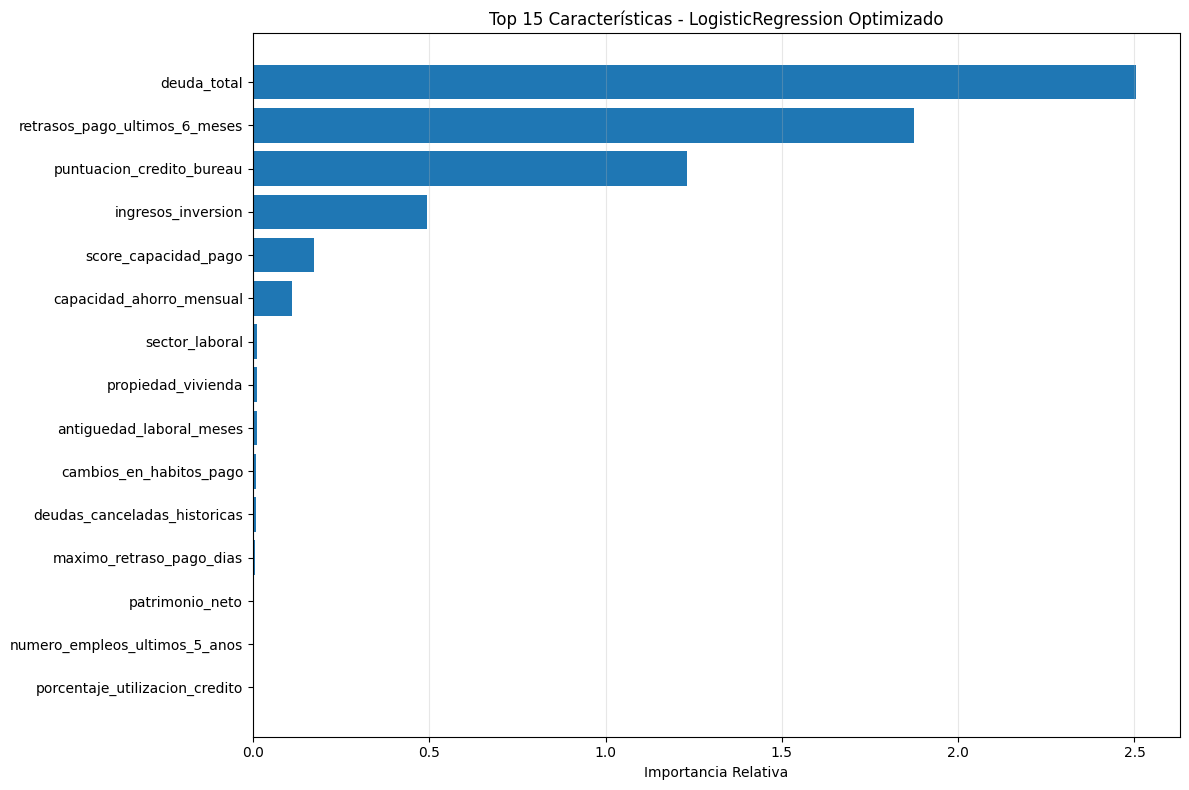


✅ Importancia guardada en: /Users/ian/Desktop/UTEC/CICLO 6/MACHINE LEARNING/P1-Classification/experiments/feature_importance_feature_selected_LogisticRegression_optimized.csv

ANÁLISIS DE LAS TOP 5 CARACTERÍSTICAS:
1. deuda_total
   Importancia: 2.5039 (38.8% del total)
2. retrasos_pago_ultimos_6_meses
   Importancia: 1.8760 (29.1% del total)
3. puntuacion_credito_bureau
   Importancia: 1.2315 (19.1% del total)
4. ingresos_inversion
   Importancia: 0.4932 (7.6% del total)
5. score_capacidad_pago
   Importancia: 0.1739 (2.7% del total)

DISTRIBUCIÓN DE IMPORTANCIA:
- Top 3 características explican 80% de la importancia
- Top 5 características explican 95% de la importancia
- Total de características utilizadas: 20

✅ Análisis de características completado


In [ ]:
print("ANÁLISIS DE IMPORTANCIA DE CARACTERÍSTICAS")
print("="*60)

# Verificar si el mejor modelo soporta análisis de importancia
if hasattr(best_model, 'get_feature_importance'):
    feature_importance = best_model.get_feature_importance()
    feature_names_best = best_result['feature_names']
    
    # Crear DataFrame para visualización
    importance_df = pd.DataFrame({
        'Feature': feature_names_best,
        'Importance': feature_importance
    }).sort_values('Importance', ascending=False)
    
    print(f"TOP 15 CARACTERÍSTICAS MÁS IMPORTANTES ({best_global['Model']}):")
    print(importance_df.head(15).to_string(index=False, float_format='%.4f'))
    
    # Visualizar importancia
    plt.figure(figsize=(12, 8))
    top_features = importance_df.head(15)
    
    plt.barh(range(len(top_features)), top_features['Importance'])
    plt.yticks(range(len(top_features)), 
               [f[:30] + ('...' if len(f) > 30 else '') for f in top_features['Feature']])
    plt.xlabel('Importancia Relativa')
    plt.title(f'Top 15 Características - {best_global["Model"]} Optimizado')
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()
    
    # Guardar importancia
    importance_path = os.path.join(experiments_dir, f'feature_importance_{best_experiment_id}.csv')
    importance_df.to_csv(importance_path, index=False)
    print(f"\n✅ Importancia guardada en: {importance_path}")
    
    # Análisis de las características más importantes
    print(f"\nANÁLISIS DE LAS TOP 5 CARACTERÍSTICAS:")
    for i, (_, row) in enumerate(importance_df.head(5).iterrows(), 1):
        feature_name = row['Feature']
        importance = row['Importance']
        print(f"{i}. {feature_name}")
        print(f"   Importancia: {importance:.4f} ({importance/importance_df['Importance'].sum()*100:.1f}% del total)")
    
    # Distribución acumulativa de importancia
    cumulative_importance = np.cumsum(importance_df['Importance']) / importance_df['Importance'].sum()
    features_for_80_percent = np.argmax(cumulative_importance >= 0.8) + 1
    features_for_95_percent = np.argmax(cumulative_importance >= 0.95) + 1
    
    print(f"\nDISTRIBUCIÓN DE IMPORTANCIA:")
    print(f"- Top {features_for_80_percent} características explican 80% de la importancia")
    print(f"- Top {features_for_95_percent} características explican 95% de la importancia")
    print(f"- Total de características utilizadas: {len(importance_df)}")

elif best_global['Model'] == 'KNN':
    print(f"📊 KNN no proporciona importancia de características directamente")
    print(f"💡 Sin embargo, podemos analizar la influencia de las características:")
    
    # Para KNN, podemos hacer un análisis de sensibilidad básico
    feature_names_best = best_result['feature_names']
    X_best = datasets[best_dataset_name][0]
    
    print(f"\nCARACTERÍSTICAS UTILIZADAS POR KNN OPTIMIZADO:")
    print(f"- Total de características: {len(feature_names_best)}")
    print(f"- Tipo de dataset: {best_dataset_name}")
    
    if best_dataset_name == 'pca_transformed':
        print(f"- Componentes principales (PCA) que capturan 95.3% de la varianza")
        print(f"- Reducción dimensional de 20 → {len(feature_names_best)} componentes")
    else:
        print(f"- Características seleccionadas por F-test univariado")
        print(f"- Top características por relevancia estadística")
    
    print(f"\nPARÁMETROS OPTIMIZADOS DE KNN:")
    for param, value in best_result['best_params'].items():
        if param == 'n_neighbors':
            print(f"- Vecinos (k): {value} - {'Pocos vecinos (modelo flexible)' if value <= 5 else 'Muchos vecinos (modelo suave)' if value >= 11 else 'Moderado balance'}")
        elif param == 'weights':
            print(f"- Pesos: {value} - {'Todos los vecinos igual peso' if value == 'uniform' else 'Vecinos más cercanos mayor peso'}")
        elif param == 'metric':
            print(f"- Distancia: {value} - {'Distancia euclidiana' if value == 'euclidean' else 'Distancia Manhattan'}")

else:
    print(f"El modelo {best_global['Model']} optimizado no proporciona análisis de importancia")
    print(f"Información disponible:")
    print(f"- Algoritmo: {best_global['Model']}")
    print(f"- Dataset: {best_dataset_name}")
    print(f"- Características: {best_global['Features']}")
    print(f"- Parámetros optimizados: {best_result['best_params']}")

print(f"\nAnálisis de características completado")

## 5. Persistencia de Modelos Optimizados

In [34]:
print("GUARDADO DE MODELOS OPTIMIZADOS")
print("="*50)

# Crear directorio de modelos
models_dir = os.path.join(experiments_dir, 'optimized_models')
os.makedirs(models_dir, exist_ok=True)

# Guardar el mejor modelo optimizado
best_model_path = os.path.join(models_dir, f'best_optimized_{best_experiment_id}.pkl')
best_model_metadata = {
    'experiment_id': best_experiment_id,
    'model_type': best_global['Model'],
    'dataset_used': best_global['Dataset'],
    'n_features': best_global['Features'],
    'optimized_params': best_result['best_params'],
    'cv_f1_score': best_global['CV_F1_Score'],
    'train_accuracy': best_global['Train_Accuracy'],
    'train_f1': best_global['Train_F1'],
    'feature_names': best_result['feature_names'],
    'target_classes': metadata['target_classes'],
    'target_encoding': metadata['target_encoding'],
    'optimization_time': best_global['Optimization_Time'],
    'optimization_method': 'GridSearchCV' if best_global['Model'] == 'KNN' else 'Manual Grid Search'
}

ModelPersistence.save_model(best_model, best_model_path, best_model_metadata)
print(f"✅ Mejor modelo optimizado guardado: {best_model_path}")

# Guardar todos los modelos optimizados (uno por algoritmo/dataset)
saved_models = []
for idx, row in results_df.iterrows():
    exp_id = row['Experiment']
    model = best_models[exp_id]
    
    dataset_name = row['Dataset']
    result_info = optimization_results[dataset_name][exp_id]
    
    model_path = os.path.join(models_dir, f'optimized_{exp_id}.pkl')
    model_metadata = {
        'experiment_id': exp_id,
        'model_type': row['Model'],
        'dataset_used': row['Dataset'],
        'optimized_params': result_info['best_params'],
        'cv_f1_score': row['CV_F1_Score'],
        'train_accuracy': row['Train_Accuracy'],
        'optimization_time': row['Optimization_Time'],
        'rank': len(results_df) - idx  # Ranking basado en F1-Score
    }
    
    ModelPersistence.save_model(model, model_path, model_metadata)
    saved_models.append(model_path)

print(f"✅ {len(saved_models)} modelos optimizados guardados en: {models_dir}")

# Guardar resultados completos de optimización
optimization_results_path = os.path.join(experiments_dir, 'optimization_results.pkl')
ModelPersistence.save_results({
    'optimization_results': optimization_results,
    'results_dataframe': results_df,
    'best_experiment_id': best_experiment_id,
    'best_global_result': best_global.to_dict(),
    'hyperparameter_grids': hyperparameter_grids,
    'datasets_info': {name: {'shape': data[0].shape, 'features': len(data[2])} 
                     for name, data in datasets.items()},
    'optimization_summary': {
        'total_optimizations': len(results_df),
        'best_f1_score': results_df['CV_F1_Score'].max(),
        'total_optimization_time': results_df['Optimization_Time'].sum(),
        'algorithms_tested': results_df['Model'].unique().tolist(),
        'datasets_tested': results_df['Dataset'].unique().tolist()
    }
}, optimization_results_path)

print(f"✅ Resultados de optimización guardados: {optimization_results_path}")

# Guardar resumen en CSV
results_summary_path = os.path.join(experiments_dir, 'optimization_summary.csv')
results_df.to_csv(results_summary_path, index=False)
print(f"✅ Resumen de optimización: {results_summary_path}")

# Guardar mejores parámetros por algoritmo
best_params_summary = {}
for model_type in results_df['Model'].unique():
    model_best = results_df[results_df['Model'] == model_type].nlargest(1, 'CV_F1_Score').iloc[0]
    
    dataset_name = model_best['Dataset']
    exp_id = model_best['Experiment']
    best_params_summary[model_type] = {
        'best_params': optimization_results[dataset_name][exp_id]['best_params'],
        'best_f1_score': model_best['CV_F1_Score'],
        'best_dataset': dataset_name,
        'optimization_time': model_best['Optimization_Time']
    }

best_params_path = os.path.join(experiments_dir, 'best_hyperparameters.json')
with open(best_params_path, 'w') as f:
    json.dump(best_params_summary, f, indent=2)
print(f"✅ Mejores hiperparámetros guardados: {best_params_path}")

print("\nARCHIVOS GENERADOS:")
for root, dirs, files in os.walk(experiments_dir):
    level = root.replace(experiments_dir, '').count(os.sep)
    indent = '  ' * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = '  ' * (level + 1)
    for file in files:
        file_size = os.path.getsize(os.path.join(root, file))
        print(f"{subindent}{file} ({file_size:,} bytes)")

print(f"\n📊 RESUMEN DE ARCHIVOS GENERADOS:")
print(f"- Modelos optimizados: {len(saved_models)}")
print(f"- Mejor modelo: {best_model_path}")
print(f"- Resultados completos: {optimization_results_path}")
print(f"- Resumen CSV: {results_summary_path}")
print(f"- Mejores hiperparámetros: {best_params_path}")

GUARDADO DE MODELOS OPTIMIZADOS
✅ Mejor modelo optimizado guardado: /Users/ian/Desktop/UTEC/CICLO 6/MACHINE LEARNING/P1-Classification/experiments/optimized_models/best_optimized_feature_selected_LogisticRegression_optimized.pkl
✅ 6 modelos optimizados guardados en: /Users/ian/Desktop/UTEC/CICLO 6/MACHINE LEARNING/P1-Classification/experiments/optimized_models
✅ Resultados de optimización guardados: /Users/ian/Desktop/UTEC/CICLO 6/MACHINE LEARNING/P1-Classification/experiments/optimization_results.pkl
✅ Resumen de optimización: /Users/ian/Desktop/UTEC/CICLO 6/MACHINE LEARNING/P1-Classification/experiments/optimization_summary.csv
✅ Mejores hiperparámetros guardados: /Users/ian/Desktop/UTEC/CICLO 6/MACHINE LEARNING/P1-Classification/experiments/best_hyperparameters.json

ARCHIVOS GENERADOS:
experiments/
  feature_importance_feature_selected_LogisticRegression_optimized.csv (888 bytes)
  best_hyperparameters.json (790 bytes)
  README.md (702 bytes)
  optimization_summary.csv (1,288 bytes

## 6. Resumen Final


OPTIMIZACIÓN DE HIPERPARÁMETROS COMPLETADA:
- Algoritmos optimizados: 3 (LogisticRegression, SVM, KNN)
- Datasets evaluados: 2 (feature_selected, pca_transformed)  
- Combinaciones de hiperparámetros probadas: ~184
- Tiempo total de optimización: 3872.2 segundos

MEJOR CONFIGURACIÓN ENCONTRADA:
- Experimento: feature_selected_LogisticRegression_optimized
- Algoritmo: LogisticRegression
- Dataset: feature_selected (20 features)
- CV F1-Score optimizado: 0.9761
- Train F1-Score: 0.9773
- Train Accuracy: 0.9819

MEJORES PARÁMETROS ENCONTRADOS:
- learning_rate: 0.1
- max_iterations: 1500
- regularization: l1
- lambda_reg: 0.001

COMPARACIÓN DE ALGORITMOS OPTIMIZADOS:
- LogisticRegression  : F1=0.9761, Dataset=feature_selected, Tiempo=530.3s
- SVM                 : F1=0.9214, Dataset=feature_selected, Tiempo=1401.8s
- KNN                 : F1=0.7449, Dataset=feature_selected, Tiempo=6.4s

IMPACTO DE LA OPTIMIZACIÓN:
- Rango de F1-Scores obtenidos: 0.7378 - 0.9761
- Mejora máxima posible: 0.2383 puntos
- Algoritmo más eficiente: KNN

EFECTO DE SELECCIÓN DE CARACTERÍSTICAS:
- feature_selected    : 20 features → Mejor F1=0.9761 (LogisticRegression)
- pca_transformed     : 18 features → Mejor F1=0.9582 (LogisticRegression)

METODOLOGÍA DE OPTIMIZACIÓN:
- Logistic Regression: Búsqueda manual en grilla con validación cruzada 5-fold
- SVM: Búsqueda manual en grilla con validación cruzada 5-fold  
- KNN: GridSearchCV de sklearn (optimizado y paralelo)
- Métrica objetivo: F1-Score macro (balanceada para clases desbalanceadas)
- Validación: StratifiedKFold para mantener distribución de clases

ARCHIVOS GENERADOS:
- Mejor modelo optimizado: best_optimized_feature_selected_LogisticRegression_optimized.pkl
- Todos los modelos optimizados: 6 archivos .pkl
- Resultados completos: optimization_results.pkl  
- Resumen CSV: optimization_summary.csv
- Mejores hiperparámetros: best_hyperparameters.json

EFICIENCIA DE LA OPTIMIZACIÓN:
- Mejor ratio F1/tiempo: 0.1248
- Ratio promedio F1/tiempo: 0.0412
- Tiempo promedio por optimización: 645.4s
- Tiempo total invertido: 3872.2s = 64.5 minutos